<a href="https://colab.research.google.com/github/NicholasBaraghini/Ball-and-Beam-system-Optimal-Control/blob/main/OPTCON_Grp21_Ball_and_Beam_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**OPTIMAL CONTROL EXAM PROJECT**

 Group 21:
   - Baraghini Nicholas 0000984041 
   - Curto Fabio
   - Iadarola Federico

In [1]:
# Libraries
import numpy as np
import matplotlib

import system_dynamic as sd
import optcon as opt
import cost_function
import matplotlib.pyplot as plt_
import Reference_Trajectory as RT
%matplotlib widget

import visualization as visu

**TRAJECTORY EXPLORATION** (Task 1)

In [2]:
# PARAMETERS SETTING

max_iterations = 7;
STOP_ITER = 1E-1; #Stop Iteration descent threshold

#step_size = 0.1;
cc = 0.05
beta = 0.5

nx = 4  # nmumber of states
nu = 1  # number of inputs
tf = 30 # seconds

params = {'tf': tf, # Seconds
          'dt':0.01,   # Step size - Forward Euler method
          'gg':9.81,    # gravitational acceleration [m/s^2]
          'mm':6.4352E-5,    # ball mass [kg]
          'rr':0.0127,   # ball radius [m]
          'ii': 3.2691E-8, # ball inertia [kg*m^2]
          'II':0.0083,  # beam inertia [kg*m^2]
          'dim_X': nx,
          'dim_U': nu,
          'LL':1,        # beam lenght [m]
          'QQ':np.array([[400, 0, 0 , 0],
                        [ 0 ,0, 0 , 0],
                        [ 0 , 0,100, 0],
                        [ 0 , 0, 0 ,0]]),
          'RR':1,
          'QQ_T':np.array([[100, 0, 0 , 0],
                          [ 0 ,0, 0 , 0],
                          [ 0 , 0,100, 0],
                          [ 0 , 0, 0 ,0]])
              }

TT = int(params['tf']/params['dt']); # rounding down of the time span divided in time in number oof time intervals

**Reference Definition** \
Step reference change between two equilibria 

In [8]:
# REFERENCE DEFINITION
ref_pos = -0.8*0.5*params['LL'] # ball reference position on the beam [m]
init_pos = 0 #-0.1*0.5*params['LL'] # ball initial position on the beam [m]
ref_inp = params['mm']*params['gg']*ref_pos; # input reference torque at reference pos ref_pos
init_inp = params['mm']*params['gg']*init_pos # input reference torque at init position
# state reference definition:
xx_ref = np.zeros((nx,TT))
xx_ref[0,0:round(TT/2)] = init_pos
xx_ref[0,round(TT/2):TT] = ref_pos

# input reference definition
uu_ref = np.zeros((nu,TT))
uu_ref[0,0:round(TT/2)] = init_inp
uu_ref[0,round(TT/2):TT] = ref_inp

xx_init = np.zeros((nx,1))
xx_init[0] = init_pos # initial state


0.0


**OPTIMIZATION LOOP**

In [9]:
## ITERATION LOOP

# Initializations
xx = np.zeros((nx,TT,max_iterations)) # state tensor
xx[0,0,:] = init_pos # init ball position
uu = np.zeros((nu,TT,max_iterations)) # input tensor
uu[0,0,:] = init_inp  # init torque input

cost = np.zeros((max_iterations,1)) # cost function values memory

descent = np.zeros((max_iterations,1)) # descent vector

#initialize trajectory
kk = 0
for tt in range(0,TT-1):

    uu_tk = uu[:, tt:tt + 1, kk:kk + 1] # shape (1,1,1)
    uu_ref_tt = uu_ref[:, tt:tt + 1] # shape (1,1)
    xx_tk = xx[:, tt:tt + 1, kk:kk + 1] # shape (4,1,1)
    xx_ref_tt = xx_ref[:, tt:tt + 1] # shape (4,1)

    cost_temp = cost_function.Stage_Cost(xx_tk, uu_tk, xx_ref_tt, uu_ref_tt, params)['cost_t']
    cost[kk] = cost[kk] + cost_temp[0]

xx_Tk = xx[:,TT-1:TT,kk:kk+1]
xx_ref_TT = xx_ref[:,TT-1:TT]
cost_temp = cost_function.Terminal_Cost(xx_Tk, xx_ref_TT,params)['cost_T']

cost[kk] = cost[kk] + cost_temp[0]
print('Initial cost : ', cost[kk])

# LOOP
for kk in range(0,max_iterations-1):

    KK = np.zeros((nu,nx,TT))
    SS = np.zeros((nu,TT)) #Sigma
    pp = np.zeros((nx,TT))
    PP = np.zeros((nx,nx,TT))
    dd = 0
    # Computation of the K, p, P, Sigma, and descent
    KK,SS,PP,pp,dd = opt.DDP_comp_t_k(kk, xx, uu, xx_ref, uu_ref, TT, params).values()
    gammas = opt.Armijo(kk, xx, uu, xx_init, xx_ref, uu_ref, TT, cost, descent[kk], cc, beta, SS, KK, pp, params)
    xx,uu,cost = opt.Trajectory_Update(kk, xx, uu, xx_ref, uu_ref, xx_init, TT, cost, gammas[-1], SS, KK, pp, params).values()

    dd = np.reshape(dd, 1)

    print('iteration:  {}'.format(kk ))
    print('cost:       {}'.format(cost[kk]))
    print('descent:    {}'.format( dd), end='\n')


    if np.abs(dd)<STOP_ITER: #STOP CRITERION
       Max_Iter = kk
       print("GJ WP")
       break
    descent[kk] = dd
    Max_Iter = kk


Initial cost :  [95952.00009559]
DDP_comp FINISHED
ARMIJO found
iteration:  0
cost:       [95952.00009559]
descent:    [-56217.94905355]
DDP_comp FINISHED
ARMIJO found
iteration:  1
cost:       [1042.91909491]
descent:    [-8.52747778]
DDP_comp FINISHED
ARMIJO found
iteration:  2
cost:       [1042.39518492]
descent:    [-0.47144837]
DDP_comp FINISHED
ARMIJO found
iteration:  3
cost:       [1042.39451586]
descent:    [-5.56826544e-06]
GJ WP


/home/fede/home/fede/Software/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


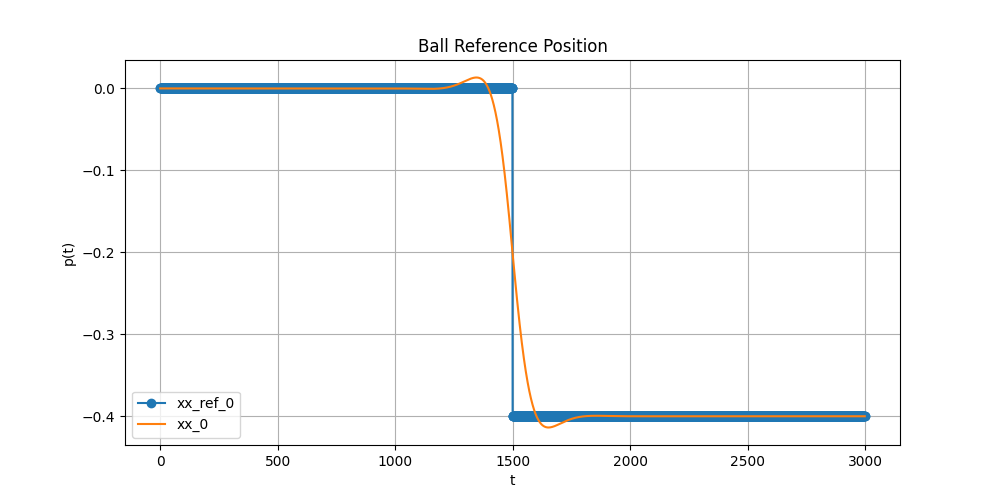

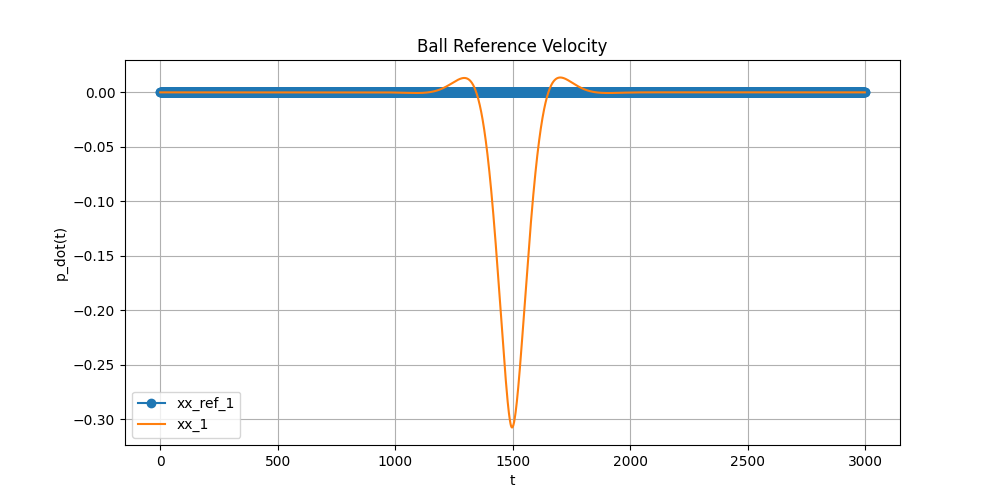

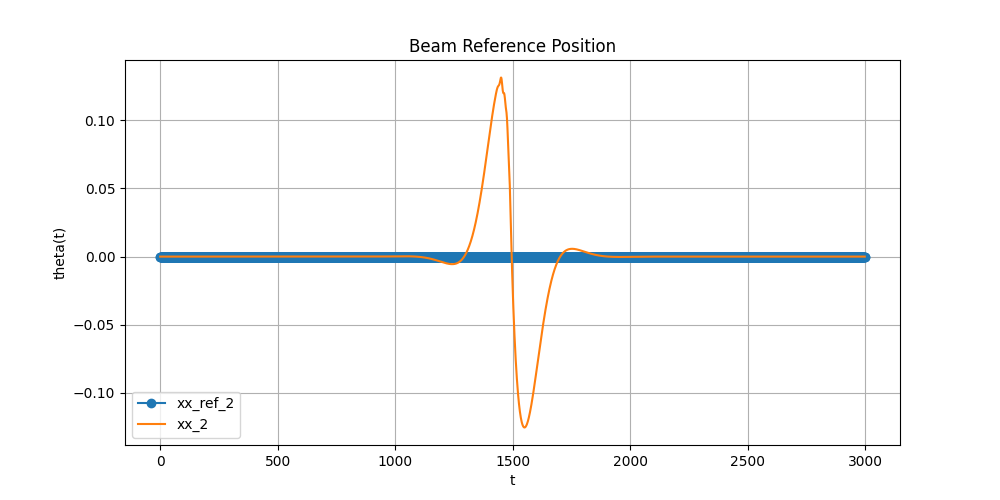

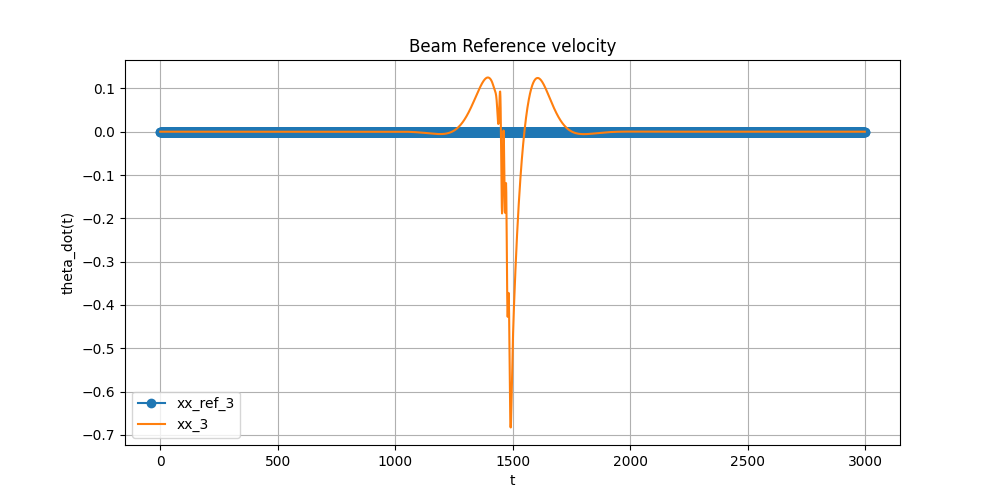

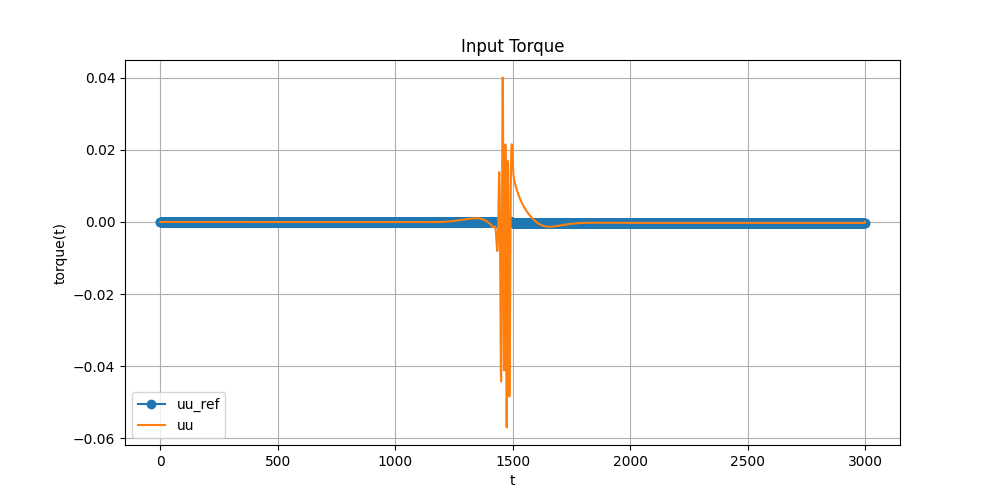

In [13]:
# Plotting the Graph
t = range(0,TT)
fig0, ax0 = plt_.subplots(figsize=(10, 5))
ax0.plot(t, xx_ref[0, :], 'o-', label='xx_ref_0')
ax0.plot(t, xx[0, :,Max_Iter], '-', label='xx_0')
ax0.legend(loc='lower left', ncol=1)
plt_.title("Ball Reference Position")
plt_.xlabel("t")
plt_.ylabel("p(t)")
plt_.grid()
plt_.show()

# Plotting the Graph
t = range(0,TT)
fig1, ax1 = plt_.subplots(figsize=(10, 5))
ax1.plot(t, xx_ref[1, :], 'o-', label='xx_ref_1')
ax1.plot(t, xx[1, :,Max_Iter], '-', label='xx_1')
ax1.legend(loc='lower left', ncol=1)
plt_.title("Ball Reference Velocity")
plt_.xlabel("t")
plt_.ylabel("p_dot(t)")
plt_.grid()
plt_.show()

# Plotting the Graph
t = range(0,TT)
fig2, ax2 = plt_.subplots(figsize=(10, 5))
ax2.plot(t, xx_ref[2, :], 'o-', label='xx_ref_2')
ax2.plot(t, xx[2, :,Max_Iter], '-', label='xx_2')
ax2.legend(loc='lower left', ncol=1)
plt_.title("Beam Reference Position")
plt_.xlabel("t")
plt_.ylabel("theta(t)")
plt_.grid()
plt_.show()

# Plotting the Graph
t = range(0,TT)
fig3, ax3 = plt_.subplots(figsize=(10, 5))
ax3.plot(t, xx_ref[3, :], 'o-', label='xx_ref_3')
ax3.plot(t, xx[3, :,Max_Iter], '-', label='xx_3')
ax3.legend(loc='lower left', ncol=1)
plt_.title("Beam Reference velocity")
plt_.xlabel("t")
plt_.ylabel("theta_dot(t)")
plt_.grid()
plt_.show()

# Plotting the Graph
t = range(0,TT)
fig, ax = plt_.subplots(figsize=(10, 5))
ax.plot(t, uu_ref[0, :], 'o-', label='uu_ref')
ax.plot(t, uu[0, :,Max_Iter], '-', label='uu')
ax.legend(loc='lower left', ncol=1)
plt_.title("Input Torque")
plt_.xlabel("t")
plt_.ylabel("torque(t)")
plt_.grid()
plt_.show()

In [6]:
#Visual_animation = 1
#    x_limit = params['LL']
#    y_limit = params['LL']
#    history_len = 500;
#    ball_rad = params['rr']
#    beam_len = params['LL']
#    frame_rate = params['dt']
#    theta = xx[2, :, Max_Iter:Max_Iter+1]
#    Xp    = xx[0, :, Max_Iter:Max_Iter+1]

#    visu.animate(x_limit,
#                 y_limit,
#                 history_len,
#                 ball_rad,
#                 beam_len,
#                 frame_rate,
#                 theta,
#                 Xp )